In [1]:
%pylab inline
import calin.calib.spe_fit
import calin.math.histogram
import calin.math.optimizer
import calin.math.pdf_1d

Populating the interactive namespace from numpy and matplotlib


## Load data and plot histogram

In [2]:
fernandez_data = loadtxt('../../calib/fernandez_dc_1.5kV_6.45V.dat');
mes_hist = calin.math.histogram.SimpleHist(1.0)
mes_hist.insert_vec(fernandez_data);

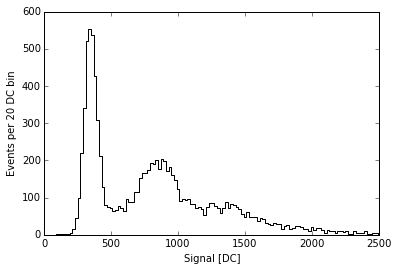

In [3]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_data.pdf')

## Fit of single-Gaussian model

In [4]:
ped_gauss_pdf = calin.math.pdf_1d.GaussianPDF()

In [5]:
ses_g_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
mes_model_g = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_g_pdf, ped_gauss_pdf)
like_g = calin.calib.spe_fit.SPELikelihood(mes_model_g, mes_hist)
opt_g = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", like_g)
opt_g.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_g.set_abs_tolerance(0.0001);
opt_g.set_initial_values([1.0, 355.0, 10.0, 500.0, 200.0]);
opt_g.set_limits_lo([0.01, 300.0, 0.1, 100.0, 10.0])
opt_g.set_limits_hi([2.0,  400.0, 100.0, 1000.0, 500.0])
status, xopt_g, fval_g = opt_g.minimize()
print(status, xopt_g, fval_g)
status, err_mat_g = opt_g.calc_error_matrix()
xerr_g = sqrt(err_mat_g.diagonal())
print(xerr_g)

Optimization using NLOPT_LD_LBFGS (requires: gradient)
- stopping criteria: dF < 0.0001
- function: N_dim = 5, provides: gradient
List of function dimensions: 
# Name            Lo bound Hi bound Stepsize
0 light_intensity 0.01     2        1       
1 ped.mean        300      400      1       
2 ped.rms         0.1      100      1       
3 ses.mean        100      1000     1       
4 ses.rms         10       500      1       
1   81875.36057 81875.36057        -inf       -inf     0.021
2   81316.76299 81316.76299  -558.59758 -6.869e-03     0.035
3   80877.34943 80877.34943  -439.41357 -5.433e-03     0.049
4   80587.40842 80587.40842  -289.94100 -3.598e-03     0.062
5   80365.88352 80365.88352  -221.52491 -2.756e-03     0.080
6   73673.92029 73673.92029 -6691.96323 -9.083e-02     0.096
7   73440.75563 73440.75563  -233.16466 -3.175e-03     0.142
8   72985.41754 72985.41754  -455.33809 -6.239e-03     0.200
9   72838.12615 72838.12615  -147.29139 -2.022e-03     0.222
10  72693.12001 72693

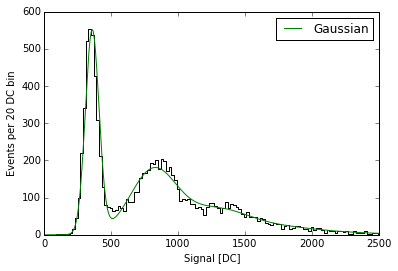

In [6]:
ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))
mes_model_g.set_parameter_values(xopt_g)
ymodel_g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_g,'g',lw=1, label='Gaussian')
legend()
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_gaussian_fit.pdf')

## Fit of exponential/Gaussian model

In [7]:
ses_eg_exp_pdf = calin.math.pdf_1d.LimitedExponentialPDF(0,numpy.inf,mes_hist.dxval())
ses_eg_exp_pdf.limit_scale(0.1, inf);
ses_eg_gauss_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_eg_pdf = calin.math.pdf_1d.TwoComponentPDF(ses_eg_exp_pdf, "exp", ses_eg_gauss_pdf, "gauss")
mes_model_eg = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_eg_pdf, ped_gauss_pdf)
like_eg = calin.calib.spe_fit.SPELikelihood(mes_model_eg, mes_hist)
opt_eg = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", like_eg)
#opt_eg.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_eg.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_eg.set_abs_tolerance(0.0001);
opt_eg.set_max_walltime(20);
opt_eg.set_max_iterations(1000);
opt_eg.set_initial_values([1.0, 355.0, 10.0, 0.1, 200.0, 500.0, 200.0]);
opt_eg.set_limits_lo([0.01, 300.0, 0.1, 0.0, 10.0, 100.0, 10.0])
opt_eg.set_limits_hi([2.0,  400.0, 100.1, 1.0, 500.0, 1000.0, 500.0])
status, xopt_eg, fval_eg = opt_eg.minimize()
print(status, xopt_eg, fval_eg)
status, err_mat_eg = opt_eg.calc_error_matrix()
xerr_eg = sqrt(err_mat_eg.diagonal())
print(xerr_eg)

Optimization using NLOPT_LD_LBFGS (requires: gradient)
- stopping criteria: dF < 0.0001 or N_eval > 1000 or T_wall > 20 sec
- function: N_dim = 7, provides: gradient
List of function dimensions: 
# Name                Lo bound Hi bound Stepsize
0 light_intensity     0.01     2        1       
1 ped.mean            300      400      1       
2 ped.rms             0.1      100.1    1       
3 ses.exp probability 0        1        1       
4 ses.exp.scale       10       500      1       
5 ses.gauss.mean      100      1000     1       
6 ses.gauss.rms       10       500      1       
1    81082.56332 81082.56332        -inf       -inf     0.040
2    81050.11942 81050.11942   -32.44390 -4.003e-04     0.060
3    79252.16072 79252.16072 -1797.95870 -2.269e-02     0.092
4    79155.66578 79155.66578   -96.49495 -1.219e-03     0.122
5    79103.19053 79103.19053   -52.47525 -6.634e-04     0.140
6    79013.96749 79013.96749   -89.22304 -1.129e-03     0.156
7    78766.90514 78766.90514  -247.06235

## Fit of double-Gaussian model

Mean of one of the Gaussians is fixed at zero in the fit

In [8]:
ses_2g_g1_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_g2_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_pdf = calin.math.pdf_1d.TwoComponentPDF(ses_2g_g1_pdf, "g1", ses_2g_g2_pdf, "g2")
mes_model_2g = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_2g_pdf, ped_gauss_pdf)
like_2g = calin.calib.spe_fit.SPELikelihood(mes_model_2g, mes_hist)
freezer = calin.math.function.FreezeThawFunction(like_2g)
freezer.freeze(4,0)
opt_2g = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", freezer)
#opt_2g.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_2g.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_2g.set_abs_tolerance(0.0001);
opt_2g.set_initial_values([1.0, 355.0, 10.0, 0.1, 200.0, 500.0, 200.0]);
status, xopt_2g, fval_2g = opt_2g.minimize()
print(status, xopt_2g, fval_2g)
status, err_mat_2g = opt_2g.calc_error_matrix()
xerr_2g = sqrt(err_mat_2g.diagonal())
print(xerr_2g)

Optimization using NLOPT_LD_LBFGS (requires: gradient)
- stopping criteria: dF < 0.0001
- function: N_dim = 7, provides: gradient
List of function dimensions: 
# Name               Lo bound Hi bound Stepsize
0 light_intensity    0        inf      1       
1 ped.mean           -inf     inf      1       
2 ped.rms            2.22507e-308 inf      1       
3 ses.g1 probability 0        1        1       
4 ses.g1.rms         2.22507e-308 inf      1       
5 ses.g2.mean        -inf     inf      1       
6 ses.g2.rms         2.22507e-308 inf      1       
1   81120.86345 81120.86345        -inf       -inf     0.042
2   86557.45814 81120.86345     0.00000  0.000e+00     0.067
3   80403.29696 80403.29696  -717.56650 -8.925e-03     0.094
4   79329.93124 79329.93124 -1073.36572 -1.353e-02     0.117
5   79311.04421 79311.04421   -18.88703 -2.381e-04     0.137
6   79008.68969 79008.68969  -302.35452 -3.827e-03     0.158
7   78613.47659 78613.47659  -395.21310 -5.027e-03     0.185
8   76470.39845 7

## Draw MES and SES plots

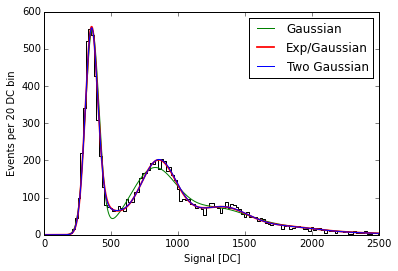

In [9]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))

mes_model_g.set_parameter_values(xopt_g)
ymodel_g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_g,'g',lw=1, label='Gaussian')

mes_model_eg.set_parameter_values(xopt_eg)
ymodel_eg = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_eg.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_eg,'r',lw=1.75, label="Exp/Gaussian")

mes_model_2g.set_parameter_values(freezer.x_in2out(xopt_2g))
ymodel_2g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_2g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_2g,'b',lw=1, label='Two Gaussian')

legend()
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_two_cpt_fits.pdf')

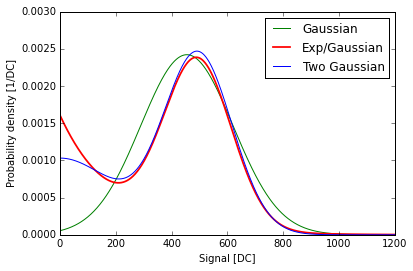

In [10]:
ses_g_y = asarray(mes_model_g.n_electron_spectrum(1));
ses_g_x = ses_g_y*0;
for i in range(0,len(ses_g_y)):
    ses_g_x[i] = mes_model_g.ses_x(i)
plot(ses_g_x, ses_g_y, 'g', label='Gaussian')

ses_eg_y = asarray(mes_model_eg.n_electron_spectrum(1));
ses_eg_x = ses_eg_y*0;
for i in range(0,len(ses_eg_y)):
    ses_eg_x[i] = mes_model_eg.ses_x(i)
plot(ses_eg_x, ses_eg_y, 'r', lw=1.75, label='Exp/Gaussian')

ses_2g_y = asarray(mes_model_2g.n_electron_spectrum(1));
ses_2g_x = ses_2g_y*0;
for i in range(0,len(ses_2g_y)):
    ses_2g_x[i] = mes_model_2g.ses_x(i)
plot(ses_2g_x, ses_2g_y, 'b', label='Two Gaussian')
legend()
axis([0,1200,0,0.003])
xlabel('Signal [DC]')
ylabel('Probability density [1/DC]')
gcf().savefig('../../../mybuild/fernandez_ses.pdf')

## Calculate gain and ENF

**Single Gaussian**

In [11]:
ses_g_norm = sum(ses_g_y)
ses_g_mean = sum(ses_g_y*ses_g_x)
ses_g_rms = sqrt(sum(ses_g_y*ses_g_x*ses_g_x) - ses_g_mean**2)
print("Norm, mean, RMS: ",ses_g_norm, ses_g_mean, ses_g_rms)
print("Resolution: ",ses_g_rms/ses_g_mean)
print("ENF: ",sqrt(1+(ses_g_rms/ses_g_mean)**2))

Norm, mean, RMS:  1.00000003804 456.422854053 163.203822421
Resolution:  0.357571539137
ENF:  1.06200631147


**Exponential/Gaussian**

In [12]:
ses_eg_norm = sum(ses_eg_y)
ses_eg_mean = sum(ses_eg_y*ses_eg_x)
ses_eg_rms = sqrt(sum(ses_eg_y*ses_eg_x*ses_eg_x) - ses_eg_mean**2)
print("Norm, mean, RMS: ",ses_eg_norm, ses_eg_mean, ses_eg_rms)
print("Resolution: ",ses_eg_rms/ses_eg_mean)
print("ENF: ",sqrt(1+(ses_eg_rms/ses_eg_mean)**2))

Norm, mean, RMS:  1.00000000063 399.395116063 202.978856468
Resolution:  0.508215669907
ENF:  1.12173221722


**Double Gaussian**

In [13]:
ses_2g_norm = sum(ses_2g_y)
ses_2g_mean = sum(ses_2g_y*ses_2g_x)
ses_2g_rms = sqrt(sum(ses_2g_y*ses_2g_x*ses_2g_x) - ses_2g_mean**2)
print("Norm, mean, RMS: ",ses_2g_norm, ses_2g_mean, ses_2g_rms)
print("Resolution: ",ses_2g_rms/ses_2g_mean)
print("ENF: ",sqrt(1+(ses_2g_rms/ses_2g_mean)**2))

Norm, mean, RMS:  1.00000000097 408.594104045 190.779843345
Resolution:  0.466917758862
ENF:  1.10363589718
